In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget


### EY analysis for the location in Golden



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode

import os
import sys

from glob import glob
from datetime import datetime
import time
from tqdm.notebook import tnrange
import timeit

# set path for NREL meteorological package and import
sys.path.append("../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync


Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/


/Users/rwitteck/coding/PVcircuit_fork/pvcircuit/EY.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Helpers


In [3]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join("data","ASTMG173.csv")
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=si_eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)
    
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    lam_eqe_saturation = lam[lam_eqe_saturation_idx]


    jscs = []
    fig,ax = plt.subplots()
    for i, col in enumerate(bandgaps):
        # print(qe_data.temperature)
        spec = spectra.iloc[i][lam]
        bandgap = bandgaps[i]
        sigma = sigmas[i]
        abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
        eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
        eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
        ax.plot(eqe_new)
        jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)

    return jscs



Some notebook settings

In [4]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day

Load the meteorological data

loading environmental from internal from 2022-06-15 00:00:00 to 2022-06-15 23:59:59


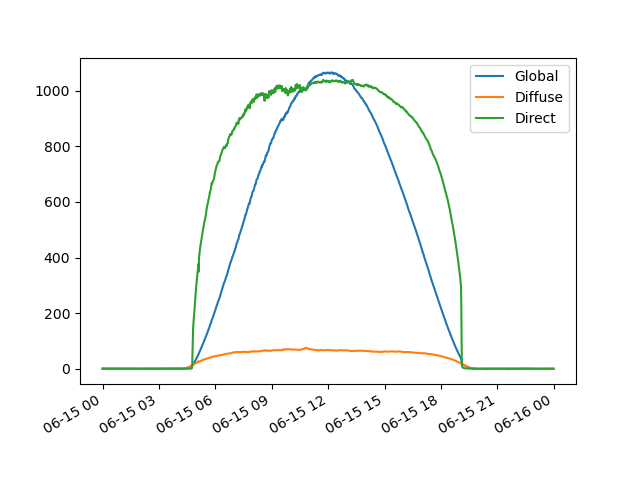

In [5]:
date_start = datetime(2022, 6, 15, 0, 0, 0)
date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
# date_start = datetime(2022, 3, 10, 0, 0, 0)  # cloudy day
# date_start = datetime(2022, 5, 1, 0, 0, 0)
# date_end = date_start.replace(month=date_start.month + 1) - pd.Timedelta(seconds=1)
date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
# date_end = date_start.replace(day=date_start.day + 1) - pd.Timedelta(seconds=1)

meteo_data = Meteorological.get_midc_environmental(date_start, date_end)

irr_list = [x for x in meteo_data.data.columns if "dir" in x.lower() and "w/m" in x.lower()]
# print(*irr_list,sep='\n')
fig, ax = plt.subplots()
# ax.plot(meteo_sync[irr_list])

# date_plot = datetime(2022, 6, 15)
date_plot = date_start
ax.plot(meteo_data.data["Global SPP (vent/cor) [W/m^2]"].loc[date_plot : date_plot + pd.Timedelta(days=1)], label="Global")
ax.plot(meteo_data.data["Diffuse CM22-1 (vent/cor) [W/m^2]"].loc[date_plot : date_plot + pd.Timedelta(days=1)], label="Diffuse")
ax.plot(meteo_data.data["Direct MS-57 [W/m^2]"].loc[date_plot : date_plot + pd.Timedelta(days=1)], label="Direct")
ax.legend()
fig.autofmt_xdate()


Load the spectral data

In [6]:
spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
# ax.plot(
#     solarsim_global_horizontal.wavelength, c, label=solarsim_global_horizontal.label
# )

# ax.legend()
# ax.set_xlim([280, 1300])
meteo_data = Meteorological.get_midc_environmental(date_start, date_end)

# resample
resampler = "2T"
spectra_resampled = spectra_class.spectra.resample(resampler).median()
meteo_resampled = meteo_data.data.resample(resampler).median()

spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

# remove nan
nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
spectra_sync = spectra_sync[~nan_filter]
meteo_sync = meteo_sync[~nan_filter]


loading SRRL WISER global tracked from 2022-06-15 00:00:00 to 2022-06-15 23:59:59
loading environmental from internal from 2022-06-15 00:00:00 to 2022-06-15 23:59:59


Replaces the day by 1 to plot the for multiple days without time shift

In [7]:
if squeeze_day_to_one_day:
    meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))

In [8]:
path = os.path.join((os.getcwd()), "data")  # Data files here
datalist = glob(path + "**" + os.path.sep +"*")
print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")


 0 --> Si_H2M2W3.8TB_JV.csv
 1 --> Si_H2M2W3_QE.xlsx
 2 --> Pvsk_1.70eV_Qi_3-22_tr.csv
 3 --> WB417n6_C_EQE.csv
 4 --> Qidarkdata.csv
 5 --> ASTMG173.csv
 6 --> Pvsk_1.75MA-free_QE.xlsx
 7 --> ISFH_32-14.csv
 8 --> Si_101_E1_005_14_2B_postITO_QE.xlsx
 9 --> JQ0411.csv
10 --> Pvsk_1.60eV_Qi_3-22_tr.csv
11 --> Pvsk_1.68eV_JV.csv
12 --> Si_ISFH-31_04_JV.csv
13 --> Pvsk0111D_1.7sb_tr.csv
14 --> MU257_3T_CZ_VB.csv
15 --> Pvsk_1.70MA-free_QE.xlsx
16 --> MU257_3T_CZ_VA.csv
17 --> Si_101_E1_005_14_2B_QE.xlsx
18 --> Pvsk_1.25eV_QE.xlsx
19 --> Pvsk_1.80MA-free_QE.xlsx
20 --> MU100.csv
21 --> Si_H2M2W3_JV.csv
22 --> MU264map2_CZ_VB.csv
23 --> Pvsk_1.63MA-free_QE.xlsx
24 --> Pvsk_1.70MA-free_JV.csv
25 --> MS874n4papy_C_CZ_JB.csv
26 --> Si153_041420hr_CR_JB.csv
27 --> Pvsk_1.63MA-free_JV.csv
28 --> USA_borders.csv
29 --> WB417n8_Cpapy_CZ_VA.csv
30 --> MU264map2_CZ_VA.csv
31 --> Si_101_E1_005_14_2B_JV.csv
32 --> MM927Bn5CEQE.csv
33 --> MS874n4papy_C_CZ_JA.csv
34 --> Si153_041420hr_CR_JA.csv
35 --> P

Scenarios to consider

In [9]:
psc_eqe_list = [x for x in datalist if "pvsk" in x.lower() and "_qe" in x.lower()]
psc_transmission_list = [x for x in datalist if "pvsk" in x.lower() and "_tr" in x.lower()]
psc_jv_list = [x for x in datalist if "pvsk" in x.lower() and "_jv" in x.lower()]
psc_transmission_evs = [os.path.basename(x).split("_") for x in psc_transmission_list]
psc_transmission_evs = [[float(i.lower().split('ev')[0]), x] for x in psc_transmission_list for i in os.path.basename(x).split("_") if 'ev' in i.lower()]

Hard code scenarios for cell data

In [10]:
# import EQE of Psk and Tandem
# Transmittance data
# Pvsk_1.53eV_Qi_3-22_tr.csv
# Pvsk_1.60eV_Qi_3-22_tr.csv
# Pvsk_1.63eV_Qi_3-22_tr.csv
# Pvsk_1.70eV_Qi_3-22_tr.csv

# PSC EQE data
# Pvsk_1.25eV_QE.xlsx
# Pvsk_1.63MA-free_QE.xlsx
# Pvsk_1.68eV_QE.xlsx
# Pvsk_1.70MA-free_QE.xlsx
# Pvsk_1.75MA-free_QE.xlsx
# Pvsk_1.80MA-free_QE.xlsx

fp_psk_eqe = [file for file in datalist if "1.25" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.53" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.25" in file and "_JV" in file][0]

fp_psk_eqe = [file for file in datalist if "1.63" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.63" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.63" in file and "_JV" in file][0]

fp_psk_eqe = [file for file in datalist if "1.68" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.70" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.68" in file and "_JV" in file][0]

fp_psk_eqe = [file for file in datalist if "1.70" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.70" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.70" in file and "_JV" in file][0]

fp_psk_eqe = [file for file in datalist if "1.75" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.70" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.75" in file and "_JV" in file][0]

fp_psk_eqe = [file for file in datalist if "1.80" in file and "_QE" in file][0]
fp_psk_trans = [file for file in datalist if "1.70" in file and "_tr" in file][0]
fp_psk_jv = [file for file in datalist if "1.80" in file and "_JV" in file][0]

# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_ISFH-31_04_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_ISFH-31_04_JV.csv" in file][0]
print(fp_psk_eqe)
print(fp_psk_trans)

reader_settings = {"index_col": 0, "usecols": [0, 1]}
df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")


/Users/rwitteck/coding/PVcircuit_fork/data/Pvsk_1.80MA-free_QE.xlsx
/Users/rwitteck/coding/PVcircuit_fork/data/Pvsk_1.70eV_Qi_3-22_tr.csv


In [11]:
fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


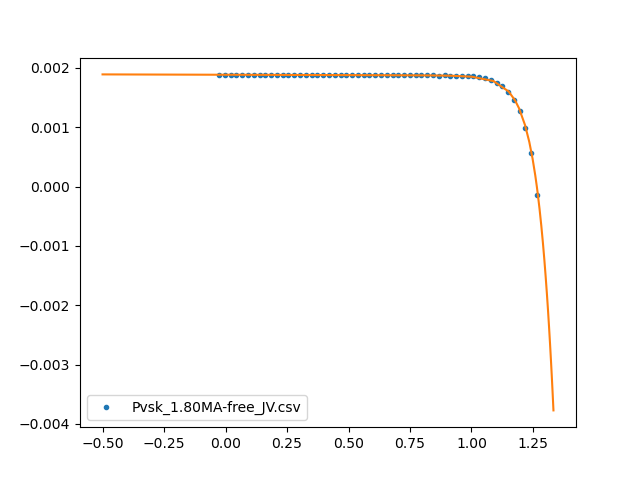

In [12]:
psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
A = 0.112  # [cm^2]
TC = 25  # [degC]
Eg = 1.7  # [eV]

# Measured terminal voltage.
voltage = psk_data["v"].to_numpy(np.double)  # [V]
# Measured terminal current.
current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A]

sort_id = np.argsort(voltage)

voltage = voltage[sort_id]
current = current[sort_id]

voc_guess_idx = np.where(current >= 0)[0][-1]
voc_guess_idx
voltage = voltage[: voc_guess_idx + 2]
current = current[: voc_guess_idx + 2]

# fit iv


(psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
    voltage, current
)
ilim = 0.6
while psc_rs < 0:
    ilim -=0.01        
    # fit iv
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current, ilim=ilim
    )
    
    
fig, ax = plt.subplots()
    
ax.plot(voltage, current, ".", label = os.path.basename(fp_psk_jv))

psc_jsc = psc_isc / A  # [A/cm^2]
n = psc_nNsVth / pvc.junction.Vth(TC)
psc_jo = psc_io / A
J0scale = 1000
Rser = psc_rs * A
Gsh = 1 / (psc_rsh * A)
# pvc.junction.DB_PREFIX
Jdb = pvc.junction.Jdb(TC=TC, Eg=Eg)
# j0=(self.Jdb * self.J0scale)**(1./self.n) * self.J0ratio / self.J0scale
J0ratio = J0scale * psc_jo / (Jdb * J0scale) ** (1.0 / n)

PVK = pvc.Multi2T(name="Psk", area=A, Jext=psc_jsc, Eg_list=[Eg], n=[n], J0ratio=[J0ratio])

PVK.set(Rs2T=Rser, Gsh=Gsh)
cp = PlotsWithControls(PVK)
# ui
Vlight, Ilight, Plight, Vlightmid, MPP = cp.calcLight(PVK)
ax.plot(Vlight,Ilight*-1, "-")
ax.legend()
# ax2.set_ylim(0.0,0.3)

Load and fit the Si IV data

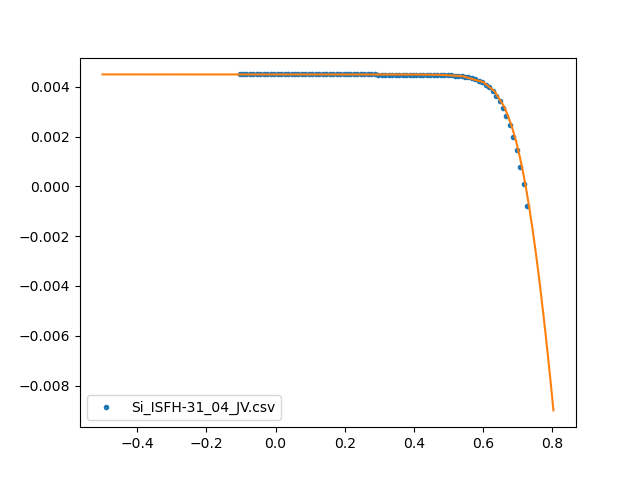

In [13]:
si_data = pd.read_csv(os.path.join(path, fp_si_jv))
A = 0.112  # [cm^2]
TC = 25  # [degC]
Eg = 1.7  # [eV]

# Measured terminal voltage.
voltage = si_data["v"].to_numpy(np.double)  # [V]
# Measured terminal current.
current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

sort_id = np.argsort(voltage)

voltage = voltage[sort_id]
current = current[sort_id]

voc_guess_idx = np.where(current >= 0)[0][-1]
voc_guess_idx
voltage = voltage[: voc_guess_idx + 2]
current = current[: voc_guess_idx + 2]

# fit iv


(si_isc, si_io, si_rs, si_rsh, si_nNsVth) = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
    voltage, current
)
ilim = 0.6
while si_rs < 0:
    ilim -=0.01        
    # fit iv
    (si_isc, si_io, si_rs, si_rsh, si_nNsVth) = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current, ilim=ilim
    )
    
    
fig, ax = plt.subplots()
    
ax.plot(voltage, current, ".", label = os.path.basename(fp_si_jv))

si_jsc = si_isc / A  # [A/cm^2]
n = si_nNsVth / pvc.junction.Vth(TC)
si_jo = si_io / A
J0scale = 1000
Rser = si_rs * A
Gsh = 1 / (si_rsh * A)
# pvc.junction.DB_PREFIX
Jdb = pvc.junction.Jdb(TC=TC, Eg=Eg)
# j0=(self.Jdb * self.J0scale)**(1./self.n) * self.J0ratio / self.J0scale
J0ratio = J0scale * si_jo / (Jdb * J0scale) ** (1.0 / n)

PVK = pvc.Multi2T(name="Psk", area=A, Jext=si_jsc, Eg_list=[Eg], n=[n], J0ratio=[J0ratio])

PVK.set(Rs2T=Rser, Gsh=Gsh)
cp = PlotsWithControls(PVK)
# ui
Vlight, Ilight, Plight, Vlightmid, MPP = cp.calcLight(PVK)
ax.plot(Vlight,Ilight*-1, "-")
ax.legend()
# ax2.set_ylim(0.0,0.3)

Create the tandem eqe from individual cell measurements

/Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'scaled EQE []')

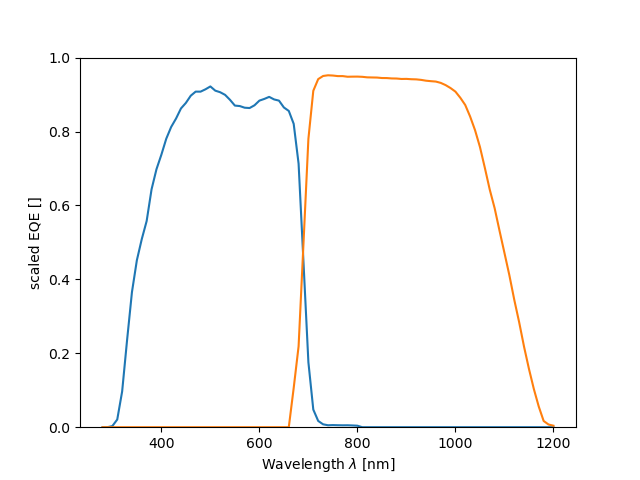

In [14]:
df_psk_trans = None
if df_psk_trans is None:
    df_psk_trans = 1 - _normalize(df_psk_eqe)
    
# in case values are percentages
if any(df_psk_eqe.values > 1):
    df_psk_eqe = df_psk_eqe.div(100)
if any(df_psk_trans.values > 1):
    df_psk_trans = df_psk_trans.div(100)
if any(df_si_eqe.values > 1):
    df_si_eqe = df_si_eqe.div(100)

# # round in case wavelength has many floating points
df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

# integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
eqe_scaler = psc_jsc * 1e3 / intergrate_eqe(df_psk_eqe)
df_psk_eqe = df_psk_eqe * eqe_scaler

eqe_scaler = si_jsc * 1e3 / intergrate_eqe(df_si_eqe)
df_si_eqe = df_si_eqe * eqe_scaler

# interpolate with eqe's superseding transmission wavelengths
comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

# get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

# commbine Psk and filter EQE
df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
df_tandem_eqe.columns = ["Psk", "Si"]

# TODO May have to move interpolation residuals e.g. EQE for psk is not zero for wavelength above 800 nm
fig,ax = plt.subplots()
ax.plot(df_tandem_eqe)
ax.set_ylim(0,1)
ax.set_xlabel("Wavelength $\lambda$ [nm]")
ax.set_ylabel("scaled EQE []")

Reindex the spectra in case the EQE contains wavelength that are not in the spectral data

In [15]:
spectra_sync = spectra_sync.reindex(comb_lam,axis=1)
spec_filter = ~spectra_sync.isna().all()
spectra_sync = spectra_sync.iloc[:,spec_filter.values]
df_tandem_eqe = df_tandem_eqe[spec_filter]
df_psk_eqe_interp = df_psk_eqe_interp[spec_filter]
df_si_eqe_interp = df_si_eqe_interp[spec_filter]
df_si_eqe_filtered = df_si_eqe_filtered[spec_filter]

Synchronixe the meteorological data with the specral data

In [16]:
# import TMY data of meteo_location
meteo_location = pvc.Meteo(
    wavelength=spectra_sync.columns,
    spectra=spectra_sync,
    ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
    wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
    daytime=spectra_sync.index,
)

Shift the bandgap of the top and bottom cells

In [17]:
eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
egs_si = si_eg_shift(meteo_location.TempCell,eg_si)
sigmas_si = si_sigma_shift(meteo_location.TempCell,sigma_si)

eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
egs_psc = psc_eg_shift(meteo_location.TempCell,eg_psc)
sigmas_psc = psc_sigma_shift(meteo_location.TempCell,sigma_psc)
# fig,ax = plt.subplots(1,2)

# ax[0].plot(meteo_location.TempCell,egs_si,"-")
# ax[0].plot(25,eg_si,"*")
# ax[1].plot(meteo_location.TempCell,sigmas_si, "-")
# ax[1].plot(25,sigma_si,"*")

/Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [18]:
# df_eqe = df_tandem_eqe
# eqe = df_eqe.to_numpy(dtype=np.float64, copy=True)
# lam = df_eqe.index.to_numpy(dtype=np.float64, copy=True)

# EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
# EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions
# EQE2J.etas[:, 0] = [1, 0.0]
# EQE2J.LCcorr()


# jo_scale = 1000
# si_n = si_nNsVth / pvc.junction.Vth(TC)
# si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
# si_joref = si_jo / A
# si_joratio = jo_scale * si_joref / (si_jdb * jo_scale) ** (1.0 / si_n)


# jo_scale = 1000
# psc_n = psc_nNsVth / pvc.junction.Vth(TC)
# psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
# psc_joref = psc_jo / A
# psc_joratio = jo_scale * psc_joref / (psc_jdb * jo_scale) ** (1.0 / psc_n)
# # j0=(self.Jdb * self.J0scale)**(1./self.n) * self.J0ratio / self.J0scale

# psc_rser = si_rs * A
# Gsh = 1 / (si_rsh * A)

# dev3T = pvc.Tandem3T()
# dev3T.set(name="PskSidev3T", Rz=1)
# dev3T.top.set(Eg=eg_psc, J0ratio=[334.49], Jext=0.0193, Gsh=4.1614e-05, Rser=0.13525, n=[1.84], J0=[1.714e-13])
# dev3T.bot.set(Eg=eg_si, J0ratio=[10.0, 15.0], Jext=0.0128, Gsh=5e-5)
# dev3T.bot.set(Rser=0.2, beta=5, area=0.89)
# dev2T = pvc.Multi2T.from_3T(dev3T)


In [19]:
psc_jsc

0.01683531509660832

Update the bottom cell jsc from tandem filterd eqe

In [20]:
si_jsc = intergrate_eqe(df_si_eqe_filtered) / 1e3

Create tandem devices

In [21]:
df_eqe = df_tandem_eqe
eqe = df_eqe.to_numpy(dtype=np.float64, copy=True)
lam = df_eqe.index.to_numpy(dtype=np.float64, copy=True)

EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions
EQE2J.etas[:, 0] = [1, 0.0]
EQE2J.LCcorr()

jo_scale = 1000

psc_n = psc_nNsVth / pvc.junction.Vth(TC)
psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
psc_joref = psc_jo / A
psc_joratio = jo_scale * psc_joref / (psc_jdb * jo_scale) ** (1.0 / psc_n)

psc_rser = psc_rs * A
psc_gsh = 1 / (psc_rsh * A)


si_n = si_nNsVth / pvc.junction.Vth(TC)
si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
si_joref = si_jo / A
si_joratio = jo_scale * si_joref / (si_jdb * jo_scale) ** (1.0 / si_n)

si_rser = si_rs * A
si_gsh = 1 / (si_rsh * A)


dev3T = pvc.Tandem3T()
dev3T.set(name="PskSidev3T", Rz=1)
dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=si_rser, n=[psc_n], J0=psc_jo)
dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n], J0=si_jo)
dev2T = pvc.Multi2T.from_3T(dev3T)


Shift the eqe according to the temperature form meteorological data

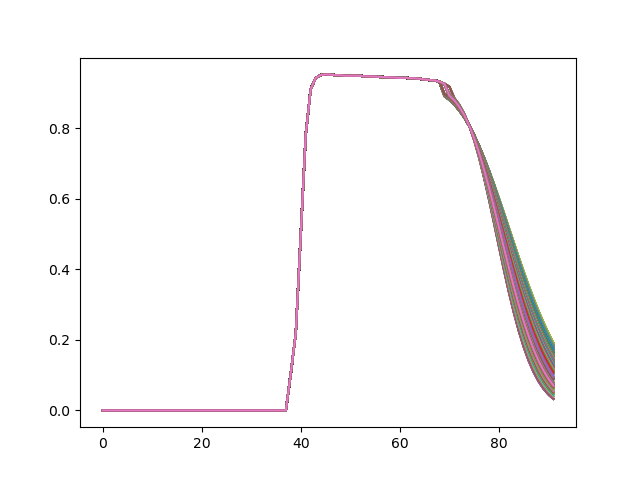

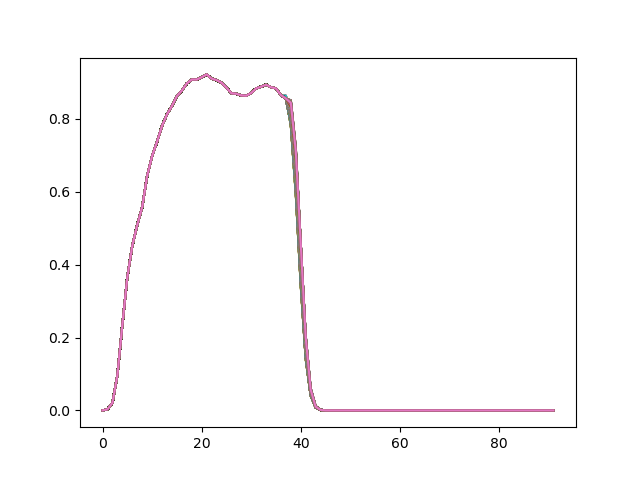

In [22]:
si_jscs = shift_eqe(
    df_si_eqe_filtered,eg_si, sigma_si, egs_si,sigmas_si, spectra_sync
)
psc_jscs = shift_eqe(
    df_psk_eqe_interp,eg_psc, sigma_psc, egs_psc,sigmas_psc, spectra_sync
)

In [23]:
# time_df = pd.date_range(pd.Timestamp.now()-pd.Timedelta(days=3),pd.Timestamp.now()-pd.Timedelta(days=1), freq="s")

# data = pd.DataFrame(np.random.randint(100,size=time_df.shape))

# int_all = np.trapz(y=data,x=time_df.astype(int),axis=0) / 1e9 / 3600
# int_all

# night_mask = (time_df.hour > 22) | (time_df.hour < 8)
# int_no_night = np.trapz(y=data[~night_mask],x=time_df[~night_mask].astype(int),axis=0) / 1e9 / 3600
# int_no_night = y=data[~night_mask].sum().values/3600

# data[night_mask] = np.nan
# int_night_nan = np.trapz(y=data,x=time_df.astype(int),axis=0) / 1e9 / 3600
# data[night_mask] = 0
# int_night_null = np.trapz(y=data,x=time_df.astype(int),axis=0) / 1e9 / 3600

# data.set_index(time_df,inplace=True)
# data = data[~night_mask]

# # int_night_resample = np.trapz(y=data,x=data.index.astype(int),axis=0) / 1e9 / 3600
# int_night_resample = data.resample('d').sum().sum().values / 3600
# fig=plt.figure()
# plt.plot(data)
# fig.autofmt_xdate()
# print(f"All = {int_all} = mask night = {int_no_night} = night nan = {int_night_nan} - night null = {int_night_null} - resample = {int_night_resample}")


In [24]:
# ui, ax, rax = EQE2J.controls(Pspec='global')
# ui
cp = PlotsWithControls(EQE2J, Pspec="global")
# ui
cp.ui


In [25]:
print(EQE2J.Jint())


[[16.894 21.909]]


In [26]:
meteo_location.cellbandgaps(EQE2J, 25)
meteo_location.cellcurrents(EQE2J, STC=True)
meteo_location.cellcurrents(EQE2J)
print(meteo_location.JscSTCs, meteo_location.RefPower, meteo_location.EnergyIn)


[[0.021 0.026]
 [0.017 0.022]
 [0.015 0.02 ]] [1348.043 1000.471  900.187] 686510.1905949999


/Users/rwitteck/coding/PVcircuit_fork/pvcircuit/qe.py:540: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  EQEfine = EQEinterp(xrange) * xrange[:, np.newaxis] * JCONST  # lambda*EQE(lambda)[lambda,junc]


In [27]:
meteo_location.Egs = np.array([egs_psc.values, egs_si.values]).T
meteo_location.Jscs = np.array([psc_jscs, si_jscs]).T/1e3

In [28]:
# # import TMY data of meteo_location
# meteo_location2 = pvc.TMY(497)
# meteo_location2.cellbandgaps(EQE2J, 25)
# meteo_location2.cellcurrents(EQE2J, STC=True)
# meteo_location2.cellcurrents(EQE2J)
# print(meteo_location2.JscSTCs, meteo_location2.RefPower, meteo_location2.YearlyEnergy)


In [29]:
# %%timeit -n 1 -r 1 -o
# cfglist = ['VM11','VM43','VM32','VM21','VM31','VM41','MPP','CM']
iref = 1  # global
ncells = 60
model = dev3T  # pointer?

operlist = pvc.EY.VMlist(2)
operlist.remove("VM11")
num = len(operlist)
ratio = [0] * num
sEY = [0] * num
rEY = [0] * num
sEYeff = [0] * num
rEYeff = [0] * num
sSTCeff = [0] * num
rSTCeff = [0] * num
sloss = [0] * num
rloss = [0] * num

t_start = time.perf_counter()
for i, oper in enumerate(operlist):
    model.bot.set(pn=1)  # s-type
    bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
    sloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
    # sSTCeff[i] = meteo_location.cellSTCeff(model, oper)
    sEY[i], sEYeff[i] = meteo_location.cellEYeff(model, oper)

    if oper in ["MPP", "CM"]:
        rEY[i], rEYeff[i] = sEY[i], sEYeff[i]

    else:
        model.bot.set(pn=-1)  # r-type
        bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
        rloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
        # rSTCeff[i] = meteo_location.cellSTCeff(model, oper)
        rEY[i], rEYeff[i] = meteo_location.cellEYeff(model, oper)
t_elaps = time.perf_counter() - t_start


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

In [30]:
# print(t_elaps)


In [31]:
# %%timeit -n 1 -r 1 -o
# cfglist = ['VM11','VM43','VM32','VM21','VM31','VM41','MPP','CM']
iref = 1  # global
ncells = 60
model = dev3T  # pointer?

operlist = pvc.EY.VMlist(2)
operlist.remove("VM11")
num = len(operlist)
ratio = [0] * num
sEYeff_MP = [0] * num
rEYeff_MP = [0] * num
sEY_MP = [0] * num
rEY_MP = [0] * num
sSTCeff = [0] * num
rSTCeff = [0] * num
sloss = [0] * num
rloss = [0] * num

t_start = time.perf_counter()
for idx, oper in enumerate(operlist):
    # for idx in tnrange(len(operlist)):
    oper = operlist[idx]
    model.bot.set(pn=1)  # s-type
    bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
    sSTCeff[idx] = meteo_location.cellSTCeff(model, oper)
    
    model.bot.set(pn=-1)  # r-type
    bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
    rSTCeff[idx] = meteo_location.cellSTCeff(model, oper)
        
for idx, oper in enumerate(operlist):
    # for idx in tnrange(len(operlist)):
    oper = operlist[idx]
    model.bot.set(pn=1)  # s-type
    bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
    sloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
    sEY_MP[idx], sEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)

    if oper in ["MPP", "CM"]:
        rEY_MP[idx], rEYeff_MP[idx] = sEY_MP[idx], sEYeff_MP[idx]

    else:
        model.bot.set(pn=-1)  # r-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        rloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
        rEY_MP[idx], rEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)
t_elapsMP = time.perf_counter() - t_start


running multiprocess wiht 8 pools


  0%|          | 0/447 [00:00<?, ?it/s]

Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
running multiprocess wiht 8 pools


  0%|          | 0/447 [00:00<?, ?it/s]

Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
running multiprocess wiht 8 pools


  0%|          | 0/447 [00:00<?, ?it/s]

Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
running multiprocess wiht 8 pools


  0%|          | 0/447 [00:00<?, ?it/s]

Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/
Tandems version 0.989
Data path is:  /Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/tandems/data/


In [32]:
print(t_elapsMP)

168.31114564905874


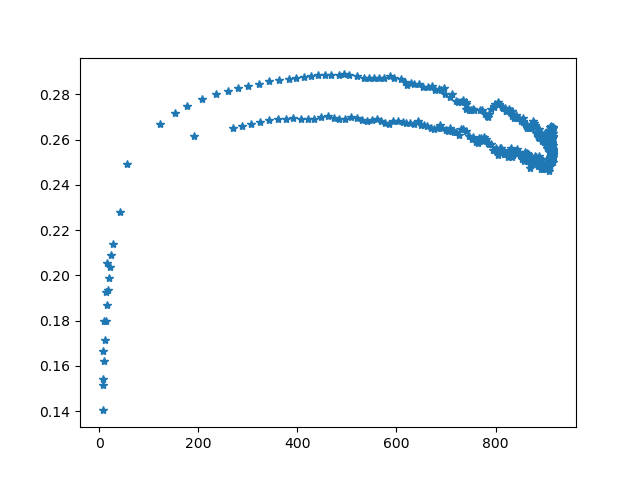

In [33]:
# print(all(meteo_location.outPower-meteo_location.outPowerMP < 1e-6))
plt.figure()
plt.plot(meteo_location.inPower, meteo_location.outPowerMP / meteo_location.inPower, "*")
# plt.plot(meteo_location.Egs, "*")
plt.show()


In [34]:
df = pd.DataFrame()
df["operlist"] = operlist
df["ratio"] = ratio
df["sEY"] = sEY_MP
df["rEY"] = rEY_MP
df["sEYeff"] = sEYeff_MP
df["rEYeff"] = rEYeff_MP
df["sSTCeff"] = sSTCeff
df["rSTCeff"] = rSTCeff
df["sloss"] = sloss
df["rloss"] = rloss
df["date_start"] = date_start
df["date_end"] = date_end
df["duration"] = t_elaps
df["durationMP"] = t_elapsMP
df["times"] = meteo_location.daytime.size
df["resampler"] = resampler
df["spectra"] = spectra_class.label


In [35]:
df

,operlist,ratio,sEY,rEY,sEYeff,rEYeff,sSTCeff,rSTCeff,sloss,rloss,date_start,date_end,duration,durationMP,times,resampler,spectra
0,MPP,-1.0,190136.358177,190136.358177,0.276961,0.276961,0.000994,0.000994,1.000000,0.000000,2022-06-15,2022-06-15 23:59:59,394.380339,168.311146,447,2T,SRRL WISER global tracked
1,CM,0.0,176953.914646,176953.914646,0.257759,0.257759,0.000807,0.000000,1.000000,0.000000,2022-06-15,2022-06-15 23:59:59,394.380339,168.311146,447,2T,SRRL WISER global tracked
2,VM21,2.0,189377.050811,178649.339465,0.275855,0.260228,0.000983,0.000983,0.966667,0.983333,2022-06-15,2022-06-15 23:59:59,394.380339,168.311146,447,2T,SRRL WISER global tracked


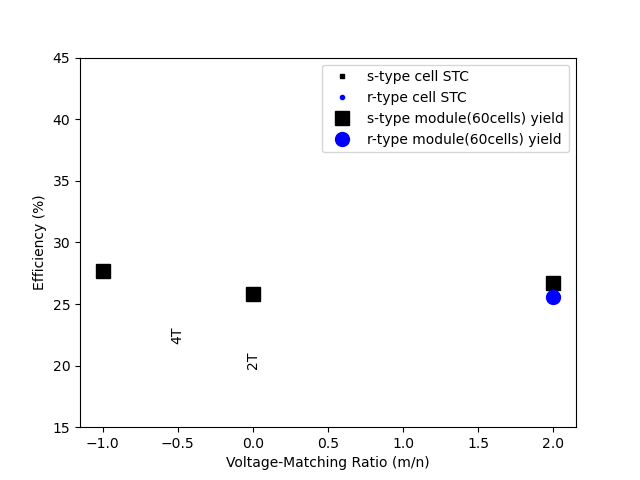

In [36]:
fig, ax = plt.subplots()
ax.plot(df["ratio"], 100 * df["sSTCeff"], c="black", ms=3, lw=0, marker="s", label="s-type cell STC")
ax.plot(df["ratio"], 100 * df["rSTCeff"], c="blue", ms=3, lw=0, marker="o", label="r-type cell STC")
ax.plot(df["ratio"], 100 * df["sEYeff"] * df["sloss"], c="black", ms=10, lw=0, marker="s", label="s-type module(60cells) yield")
ax.plot(df["ratio"], 100 * df["rEYeff"] * df["rloss"], c="blue", ms=10, lw=0, marker="o", label="r-type module(60cells) yield")
ax.set_ylim(15, 45)
ax.set_ylabel("Efficiency (%)")
ax.set_xlabel("Voltage-Matching Ratio (m/n)")
ax.text(3, 16, "3T", ha="center")
ax.text(0, 20, "2T", ha="center", rotation="vertical")
ax.text(-0.5, 22, "4T", ha="center", rotation="vertical")
ax.legend()


In [37]:
# cell = os.path.basename(fp_psk_eqe).split("_")[1]
# fig.savefig(f"./{date_start:%Y-%m-%d}_{date_end:%Y-%m-%d}_meteo_location_{resampler}_{spectra_class.label}_{cell}.png")

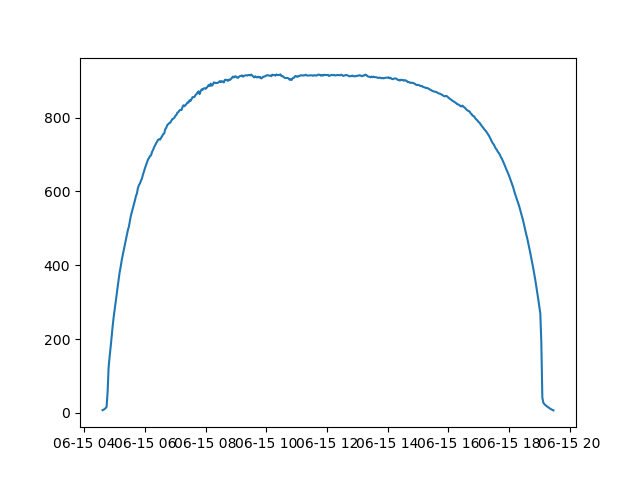

In [38]:
plt.figure()
plt.plot(meteo_sync.index, meteo_location.inPower)


In [39]:
json_settings = {"orient": "split"}
stats = pd.DataFrame(
    [
        {
            "date_start": date_start.strftime("%Y-%m-%d"),
            "date_end": date_end.strftime("%Y-%m-%d"),
            "duration": t_elaps,
            "durationMP": t_elapsMP,
            "times": meteo_location.daytime.size,
            "resampler": resampler,
        }
    ]
)

if os.path.exists("./stats.json"):
    old_stats = pd.read_json("./stats.json")
    stats = pd.concat([old_stats, stats]).reset_index(drop=True)
    stats.to_json("./stats.json")
else:
    stats.to_json("./stats.json")


/Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([0.491, 2.996])

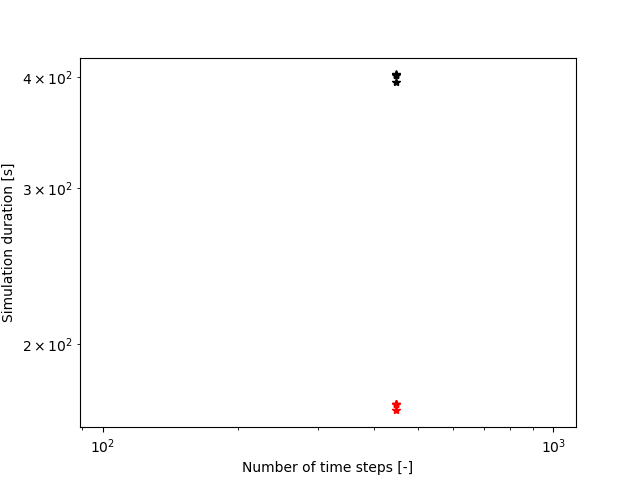

In [40]:
stats = pd.read_json("./stats.json")
fig, ax = plt.subplots()


fit = np.polyfit(
    np.log(stats["times"][~np.isnan(np.log(stats["duration"]))]), np.log(stats["duration"][~np.isnan(np.log(stats["duration"]))]), 1
)

fit_x = np.linspace(np.min(stats["times"]), np.max(stats["times"]), 50)
fit_y = np.polyval(fit, fit_x)

plt.plot(stats["times"], stats["duration"], "k*")
plt.plot(stats["times"], stats["durationMP"], "r*")
plt.plot(fit_x, fit_y, "--")
stats["duration"] / stats["times"]
# ax.set_xlim(left=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of time steps [-]")
ax.set_ylabel("Simulation duration [s]")
fit


/Users/rwitteck/coding/PVcircuit_fork/.cenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([  0.448, 200.199])

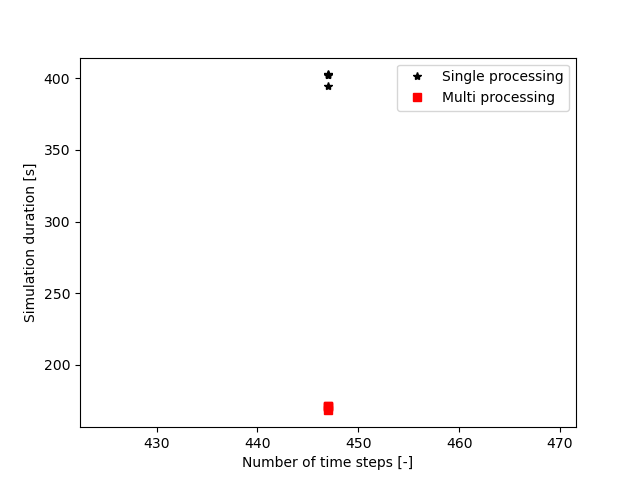

In [41]:
stats
fig, ax = plt.subplots()

# fit = np.polyfit(np.log(stats["times"]), np.log(stats["duration"]), 1)
fit = np.polyfit(stats["times"][~np.isnan(np.log(stats["duration"]))], stats["duration"][~np.isnan(np.log(stats["duration"]))], 1)


fit_x = np.linspace(np.min(stats["times"]), np.max(stats["times"]), 50)
# fit_y = np.polyval(fit, fit_x)
# fit_y = np.exp(fit[1] + fit[0] * np.log(fit_x))
fit_y = fit[1] + fit[0] * (fit_x)
# fit_y_lin = fit[1] + fit[0] * fit_x
# fit_y_lin = np.log(fit[1]) + fit_x**(fit[0])

plt.plot(stats["times"], stats["duration"], "k*", label="Single processing")
plt.plot(stats["times"], stats["durationMP"], "rs", label="Multi processing")
plt.plot(fit_x, fit_y, "--")
# plt.plot(fit_x, fit_y_lin, "--")
stats["duration"] / stats["times"]
# ax.set_xlim(left=1)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Number of time steps [-]")
ax.set_ylabel("Simulation duration [s]")

leg = ax.legend()
fit


In [42]:
# df_old = pd.read_csv("results", index_col=0)
# df_new = pd.concat([df_old, df]).reset_index(drop=True)
# df_new.to_csv("results")
